![alt text](images\box_office_banner.jpg)
# Box Office Statistical Analysis
Author: Elijah Lopez

## Overview
This analysis utilizes public data from Internet Movie Database (IMDb) and The Numbers to determine which factors make a movie a box office success. Success was defined by average reviews, return on investment (ROI), and gross revenue.

The goal of this analysis is to provide data-driven insights to help an emerging movie studio produce a box office hit! This movie studio will be able to use our findings to determine which genre to focus for their first film, a budget for the film, and when to release their movie to achieve the greatest ticket sales.

## Business Problem
Emerging movie studios are inundated with choices regarding how to grow credibility with their target audience, deciding on a genre, establishing a production budget, and determining when to premiere their new film.

## Data
This data comes from [Internet Movie Database](https://www.imdb.com/) (IMDb) and [The Numbers](https://thenumbers.com/).

In [1]:
# Imports
import pandas as pd
import sqlite3
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from matplotlib import pyplot as plt


%matplotlib inline

In [2]:
# Establish a connection to the SQLite3 database
conn = sqlite3.connect('data\im.db')

In [3]:
# Explore the data structure and primary keys
master_table = pd.read_sql("""
SELECT *
FROM sqlite_master
WHERE type = 'table'
""", conn)
master_table

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [4]:
# Explore each table's contents
print("movie_basics")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM movie_basics
LIMIT 5
""", conn))

print("directors")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM directors
LIMIT 5
""", conn))

print("known_for")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM known_for
LIMIT 5
""", conn))

print("movie_akas")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM movie_akas
LIMIT 5
""", conn))

print("movie_ratings")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM movie_ratings
LIMIT 5
""", conn))

print("persons")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM persons
LIMIT 5
""", conn))

print("principals")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM principals
LIMIT 5
""", conn))

print("writers")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM writers
LIMIT 5
""", conn))

movie_basics


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,COUNT(*)
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",146144


directors


,movie_id,person_id,COUNT(*)
0,tt0285252,nm0899854,291174


known_for


,person_id,movie_id,COUNT(*)
0,nm0061671,tt0837562,1638260


movie_akas


,movie_id,ordering,title,region,language,types,attributes,is_original_title,COUNT(*)
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0,331703


movie_ratings


,movie_id,averagerating,numvotes,COUNT(*)
0,tt10356526,8.3,31,73856


persons


,person_id,primary_name,birth_year,death_year,primary_profession,COUNT(*)
0,nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer",606648


principals


,movie_id,ordering,person_id,category,job,characters,COUNT(*)
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]",1028186


writers


,movie_id,person_id,COUNT(*)
0,tt0285252,nm0899854,255873


### IMDb Data Summary
* The [data](data\im.db) from IMDb was stored in a SQLite database which includes movie  ID, title (including alternate titles), genre, and average rating, among other things. Initially there were 146,144 movies with 331,703 alternate titles. Only 73,856 of which had average ratings figures.

In [5]:
# Open CSV from The Numbers
df = pd.read_csv('data/tn.movie_budgets.csv')
df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [7]:
df.describe(include='object')

,release_date,movie,production_budget,domestic_gross,worldwide_gross
count,5782,5782,5782,5782,5782
unique,2418,5698,509,5164,5356
top,"Dec 31, 2014",Halloween,"$20,000,000",$0,$0
freq,24,3,231,548,367


### The Numbers Data Summary
* [Data](data\tn.movie_budgets.csv) from The Numbers includes movie titles, release date, production budget, and domestic/worldwide gross sales. There were 5,782 movies listed.

## Potential Routes of Analysis:
- ROI per genre (if wanting best return on investment)
- Ratings per genre (if seeking awards and credibility)
- ROI by budget level (to determine a reasonable budget -- Low: <$5M, Medium: $5-50M, High: >$50M)
- ROI by length of movie (to determine best timeframe -- Short: <90 mins, Medium: 90-120 mins, Long: >120 mins)
- Revenue by release month (to determine best month for release)

## Chosen Metrics for Analysis
1. Ratings by Genre
2. ROI by Budget Level
3. Revenue by Release Month

## Merging the Data
In order to consolidate the data into a single dataframe I created three subsets.
* The first comes from the IMDb movie_basics and was labeled `sql_movies`
* The second comes from IMDb movie_akas and was labeled `alt_titles`
* The third comes from The Numbers csv and was labeled `df`

I created two dictionaries (one from `sql_movies` and the other from `alt_titles`) in order to match the movie title from `df` and assign a unique movie_id. Once created, I was able to merge all of the dataframes together into `merge_df`.

In [8]:
# Consolidate into one dataframe
# First combine the SQL tables
sql_movies = pd.read_sql("""
SELECT *
FROM movie_basics
    JOIN movie_ratings
        USING(movie_id)
""", conn)

sql_movies.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [9]:
sql_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [10]:
alt_titles = pd.read_sql("""
SELECT *
FROM movie_akas
""", conn)
alt_titles.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [11]:
alt_titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              168447 non-null  object 
 6   attributes         14925 non-null   object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


In [12]:
# Second, create a dictionary to match primary/alternate movie titles to the correct movie_id
movie_id_dict = dict(zip(sql_movies['primary_title'], sql_movies['movie_id']))
alt_dict = dict(zip(alt_titles['title'], alt_titles['movie_id']))
print(len(movie_id_dict))
print(len(alt_dict))

69993
252781


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [14]:
# Map the movie_id to The Numbers data
df['movie_id'] = df['movie'].map(movie_id_dict)
df['movie_id'] = df['movie_id'].fillna(df['movie'].map(alt_dict))
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",tt1775309
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",tt6565702
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",NaN
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,tt7837402
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",NaN
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",NaN
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,tt2107644


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
 6   movie_id           2508 non-null   object
dtypes: int64(1), object(6)
memory usage: 316.3+ KB


In [16]:
# Merge the dataframes using movie_id
merge_df = pd.merge(sql_movies, df, on='movie_id')
merge_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",The Secret Life of Walter Mitty,"$91,000,000","$58,236,838","$187,861,183"
2,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",A Walk Among the Tombstones,"$28,000,000","$26,017,685","$62,108,587"
3,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",Jurassic World,"$215,000,000","$652,270,625","$1,648,854,864"
4,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,94787,16,"Oct 28, 2011",The Rum Diary,"$45,000,000","$13,109,815","$21,544,732"


In [17]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2368 entries, 0 to 2367
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           2368 non-null   object 
 1   primary_title      2368 non-null   object 
 2   original_title     2368 non-null   object 
 3   start_year         2368 non-null   int64  
 4   runtime_minutes    2288 non-null   float64
 5   genres             2363 non-null   object 
 6   averagerating      2368 non-null   float64
 7   numvotes           2368 non-null   int64  
 8   id                 2368 non-null   int64  
 9   release_date       2368 non-null   object 
 10  movie              2368 non-null   object 
 11  production_budget  2368 non-null   object 
 12  domestic_gross     2368 non-null   object 
 13  worldwide_gross    2368 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 259.1+ KB


## Data Cleaning & Feature Engineering
Each of these columns needed to be stripped of the "$" and "," characters:
* production_budget
* domestic_gross
* worldwide_gross

Because there were mixed forms of reporting for domestic and worldwide gross sales I created a function to take the higher value and assigned that to a new column `revenue`. Finally, I isolated the desired columns and renamed the resulting dataframe `df_relevant`. 

In [18]:
"""
Function to replace '$' and commas from 'production_budget', 'domestic_gross', and 'worldwide_gross'
Takes in dataframe and column names
Returns cleaned version saved over the original dataframe
"""

def clean_currency_columns(df, columns):
    for column in columns:
        df.loc[:, column] = df[column].replace({'\$': '', ',': ''}, regex=True).astype(float)
    return df

In [19]:
# Defines the columns to clean
columns_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']

# Calls the function
merge_df = clean_currency_columns(merge_df, columns_to_clean)
merge_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0
1,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0
2,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",A Walk Among the Tombstones,28000000.0,26017685.0,62108587.0
3,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1648854864.0
4,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,94787,16,"Oct 28, 2011",The Rum Diary,45000000.0,13109815.0,21544732.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,tt9746500,Earth,Erde,2019,115.0,Documentary,7.3,49,36,"Apr 22, 2009",Earth,47000000.0,32011576.0,116773317.0
2364,tt9851050,Sisters,Sisters,2019,NaN,"Action,Drama",4.7,14,57,"Dec 18, 2015",Sisters,30000000.0,87044645.0,106030660.0
2365,tt9861522,Ali,Ali,2019,110.0,Drama,7.7,79,45,"Dec 25, 2001",Ali,109000000.0,58183966.0,87683966.0
2366,tt9899880,Columbus,Columbus,2018,85.0,Comedy,5.8,5,93,"Aug 4, 2017",Columbus,700000.0,1017107.0,1110511.0


In [20]:
"""
Function used to compare 'domestic_gross' and 'worldwide_gross' and return the higher value
Takes in dataframe and column names
Returns cleaned version saved over the original dataframe
"""

def calculate_revenue(row):
    if row['domestic_gross'] >= row['worldwide_gross']:
        return row['domestic_gross']
    else:
        return row['worldwide_gross']

merge_df['revenue'] = merge_df.apply(calculate_revenue, axis=1)
merge_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,revenue
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0,7.370600e+04
1,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0,1.878612e+08
2,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",A Walk Among the Tombstones,28000000.0,26017685.0,62108587.0,6.210859e+07
3,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1648854864.0,1.648855e+09
4,tt0376136,The Rum Diary,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,94787,16,"Oct 28, 2011",The Rum Diary,45000000.0,13109815.0,21544732.0,2.154473e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,tt9746500,Earth,Erde,2019,115.0,Documentary,7.3,49,36,"Apr 22, 2009",Earth,47000000.0,32011576.0,116773317.0,1.167733e+08
2364,tt9851050,Sisters,Sisters,2019,NaN,"Action,Drama",4.7,14,57,"Dec 18, 2015",Sisters,30000000.0,87044645.0,106030660.0,1.060307e+08
2365,tt9861522,Ali,Ali,2019,110.0,Drama,7.7,79,45,"Dec 25, 2001",Ali,109000000.0,58183966.0,87683966.0,8.768397e+07
2366,tt9899880,Columbus,Columbus,2018,85.0,Comedy,5.8,5,93,"Aug 4, 2017",Columbus,700000.0,1017107.0,1110511.0,1.110511e+06


In [21]:
# Define relevant columns to focus the dataframe on direction of analysis
relevant_cols = [
    'primary_title',
    'runtime_minutes',
    'genres',
    'averagerating',
    "release_date",
    'production_budget',
    'revenue'
]

df_relevant = merge_df[relevant_cols]
df_relevant

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue
0,Foodfight!,91.0,"Action,Animation,Comedy",1.9,"Dec 31, 2012",45000000.0,7.370600e+04
1,The Secret Life of Walter Mitty,114.0,"Adventure,Comedy,Drama",7.3,"Dec 25, 2013",91000000.0,1.878612e+08
2,A Walk Among the Tombstones,114.0,"Action,Crime,Drama",6.5,"Sep 19, 2014",28000000.0,6.210859e+07
3,Jurassic World,124.0,"Action,Adventure,Sci-Fi",7.0,"Jun 12, 2015",215000000.0,1.648855e+09
4,The Rum Diary,119.0,"Comedy,Drama",6.2,"Oct 28, 2011",45000000.0,2.154473e+07
...,...,...,...,...,...,...,...
2363,Earth,115.0,Documentary,7.3,"Apr 22, 2009",47000000.0,1.167733e+08
2364,Sisters,NaN,"Action,Drama",4.7,"Dec 18, 2015",30000000.0,1.060307e+08
2365,Ali,110.0,Drama,7.7,"Dec 25, 2001",109000000.0,8.768397e+07
2366,Columbus,85.0,Comedy,5.8,"Aug 4, 2017",700000.0,1.110511e+06


In [22]:
# Return on Investent (roi) is a percentage gain (or loss) of the initial budget that the movie brought in
df_relevant.loc[:, 'roi'] = ((df_relevant['revenue'] - df_relevant['production_budget']) / df_relevant['production_budget'] * 100).astype(float)
df_relevant

C:\Users\Elija\AppData\Local\Temp\ipykernel_26824\890075838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant.loc[:, 'roi'] = ((df_relevant['revenue'] - df_relevant['production_budget']) / df_relevant['production_budget'] * 100).astype(float)


,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,"Action,Animation,Comedy",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209
1,The Secret Life of Walter Mitty,114.0,"Adventure,Comedy,Drama",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860
2,A Walk Among the Tombstones,114.0,"Action,Crime,Drama",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382
3,Jurassic World,124.0,"Action,Adventure,Sci-Fi",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239
4,The Rum Diary,119.0,"Comedy,Drama",6.2,"Oct 28, 2011",45000000.0,2.154473e+07,-52.122818
...,...,...,...,...,...,...,...,...
2363,Earth,115.0,Documentary,7.3,"Apr 22, 2009",47000000.0,1.167733e+08,148.453866
2364,Sisters,NaN,"Action,Drama",4.7,"Dec 18, 2015",30000000.0,1.060307e+08,253.435533
2365,Ali,110.0,Drama,7.7,"Dec 25, 2001",109000000.0,8.768397e+07,-19.555994
2366,Columbus,85.0,Comedy,5.8,"Aug 4, 2017",700000.0,1.110511e+06,58.644429


## Analysis

### Ratings by Genre
Genres were isolated by using the `.explode()` method. Next I filtered the genres so that they only included genres where there were at least 30 films. I did this so that I could later conduct any statistical test without worrying about sample size. I created a simplified dataframe `ratings_by_genre` that included the filtered genres and average rating for each. I graphed this as a horizontal bar chart to keep the genres readable. Finally, I added color to the top three rated genres.

In [23]:
# Split 'genres' to make lists. Then use explode to list each title under each genre
df_relevant.loc[:, 'genres'] = df_relevant['genres'].str.split(',')
df_genre = df_relevant.explode('genres')
df_genre.head()

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,Action,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
0,Foodfight!,91.0,Animation,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
0,Foodfight!,91.0,Comedy,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
1,The Secret Life of Walter Mitty,114.0,Adventure,7.3,"Dec 25, 2013",91000000.0,187861183.0,106.440860
1,The Secret Life of Walter Mitty,114.0,Comedy,7.3,"Dec 25, 2013",91000000.0,187861183.0,106.440860


In [24]:
# Only a handful of nulls in runtime and in genres
df_relevant.isna().sum()

primary_title         0
runtime_minutes      80
genres                5
averagerating         0
release_date          0
production_budget     0
revenue               0
roi                   0
dtype: int64

In [25]:
genre_counts = df_genre['genres'].value_counts()
genre_counts

genres
Drama          1181
Comedy          696
Action          576
Adventure       424
Thriller        387
Crime           308
Horror          305
Romance         265
Sci-Fi          186
Mystery         178
Biography       173
Fantasy         158
Documentary     152
Family          130
Animation       121
History          69
Music            67
Sport            52
War              38
Musical          18
Western          15
News              4
Name: count, dtype: int64

In [26]:
# Exclude genres with less than 30 movies
valid_genres = genre_counts[genre_counts >= 30].index

filtered_df_genre = df_genre[df_genre['genres'].isin(valid_genres)]
filtered_df_genre

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,Action,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
0,Foodfight!,91.0,Animation,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
0,Foodfight!,91.0,Comedy,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
1,The Secret Life of Walter Mitty,114.0,Adventure,7.3,"Dec 25, 2013",91000000.0,187861183.0,106.440860
1,The Secret Life of Walter Mitty,114.0,Comedy,7.3,"Dec 25, 2013",91000000.0,187861183.0,106.440860
...,...,...,...,...,...,...,...,...
2364,Sisters,NaN,Action,4.7,"Dec 18, 2015",30000000.0,106030660.0,253.435533
2364,Sisters,NaN,Drama,4.7,"Dec 18, 2015",30000000.0,106030660.0,253.435533
2365,Ali,110.0,Drama,7.7,"Dec 25, 2001",109000000.0,87683966.0,-19.555994
2366,Columbus,85.0,Comedy,5.8,"Aug 4, 2017",700000.0,1110511.0,58.644429


In [27]:
# Focus only on genre and average rating
ratings_by_genre = filtered_df_genre.groupby('genres')['averagerating'].mean().round(1).reset_index()
ratings_by_genre = ratings_by_genre.sort_values(by='averagerating', ascending=False)
ratings_by_genre

,genres,averagerating
6,Documentary,7.1
3,Biography,7.0
10,History,6.8
16,Sport,6.7
18,War,6.6
7,Drama,6.5
12,Music,6.4
2,Animation,6.4
1,Adventure,6.4
14,Romance,6.3


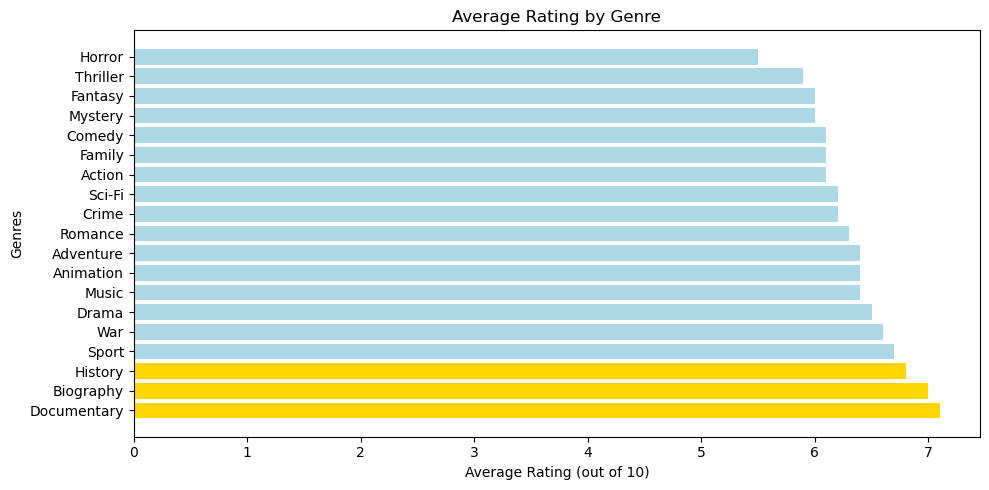

In [53]:
# Horizontal bar chart that highlights 3 highest rated genres
colors = ['gold' if i < 3 else 'lightblue' for i in range(len(ratings_by_genre))]

x =ratings_by_genre['genres']
y = ratings_by_genre['averagerating']

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(x, y, color=colors)
ax.set_title('Average Rating by Genre')
ax.set_xlabel('Average Rating (out of 10)')
ax.set_ylabel('Genres')
plt.tight_layout();
# plt.savefig('images/rec1.png')

#### Ratings by Genre Statistical Testing
Because I was comparing > 2 groups I used an Analysis of Variance (ANOVA) test to determine if there was a statistically significant difference between genres at an alpha of 0.05. My findings indicated that there was a difference so I followed up with Tukeys Honest Significant Difference (HSD) test to understand the result.

H0: There is no significant difference in average rating between genres.

H1: There is a significant difference in average rating between genres.

In [29]:
# Group the data by valid genres and collect ratings
rec1_grouped_data = filtered_df_genre.groupby('genres')['averagerating'].apply(list)
rec1_groups = [ratings for ratings in rec1_grouped_data]

# ANOVA
f_statistic, p_value = stats.f_oneway(*rec1_groups)

# Results
alpha = 0.05  # Significance level
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

if p_value < alpha:
    print("Reject the null hypothesis in favor of the alternative: There are significant differences between genre ratings.")
else:
    print("Fail to reject the null hypothesis: There are no significant differences between genre ratings.")

F-statistic: 27.94881865618258
P-value: 6.669851000073437e-91
Reject the null hypothesis in favor of the alternative: There are significant differences between genre ratings.


In [30]:
# Run Tukey's HSD test
rec1_tk_hsd = pairwise_tukeyhsd(endog=filtered_df_genre['averagerating'], 
                            groups=filtered_df_genre['genres'], 
                            alpha=0.05)

# Display the summary of results
print(rec1_tk_hsd.summary())

c:\Users\Elija\anaconda3\envs\Cohort_Env\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
     Action   Adventure   0.2718 0.0099   0.031  0.5125   True
     Action   Animation   0.3221 0.2097 -0.0542  0.6984  False
     Action   Biography   0.8706    0.0  0.5444  1.1968   True
     Action      Comedy   0.0544    1.0 -0.1575  0.2664  False
     Action       Crime   0.1353 0.9562 -0.1303  0.4009  False
     Action Documentary   1.0347    0.0  0.6916  1.3778   True
     Action       Drama   0.3755    0.0  0.1843  0.5667   True
     Action      Family   0.0487    1.0 -0.3166  0.4141  False
     Action     Fantasy  -0.0575    1.0 -0.3954  0.2804  False
     Action     History   0.6629 0.0002  0.1836  1.1423   True
     Action      Horror  -0.6339    0.0 -0.9004 -0.3674   True
     Action       Music   0.3557 0.4977   -0.13  0.8414  False
     Action     Mystery  -0.1071 0.9997 -0.4297  0.2156

In [31]:
"""
The results of this table show the combinations of movies that have statistically
higher ratings than the average. Biographies were rated higher than 10 other
genres at a statistically significant level while documentaries rated higher than 
9 and history films rated higher than 4.
"""

rec1_results = pd.DataFrame(data=rec1_tk_hsd._results_table.data[1:], 
                          columns=rec1_tk_hsd._results_table.data[0])
rec1_results.query('reject == True and (group1 == "History" or group1 == "Documentary" or group1 == "Biography")')

,group1,group2,meandiff,p-adj,lower,upper,reject
51,Biography,Comedy,-0.8162,0.0000,-1.1358,-0.4965,True
52,Biography,Crime,-0.7353,0.0000,-1.0928,-0.3778,True
54,Biography,Drama,-0.4951,0.0000,-0.8014,-0.1888,True
55,Biography,Family,-0.8219,0.0000,-1.2586,-0.3851,True
56,Biography,Fantasy,-0.9281,0.0000,-1.3422,-0.5140,True
58,Biography,Horror,-1.5045,0.0000,-1.8626,-1.1464,True
60,Biography,Mystery,-0.9776,0.0000,-1.3794,-0.5759,True
61,Biography,Romance,-0.6732,0.0000,-1.0410,-0.3054,True
62,Biography,Sci-Fi,-0.7599,0.0000,-1.1573,-0.3624,True
64,Biography,Thriller,-1.0200,0.0000,-1.3641,-0.6758,True


Recommendation 1: Create a historical movie, a biography, or a documentary.

### ROI by Budget
Common convention in the movie industry classifies budgets as follows:
* Low: < $5M
* Medium: $5-50M
* High: > $50M

When calculating `roi` I removed movies that did not have any revenue data to avoid a downward skew. The labels `low`, `medium`, and `high` were then added under `budget_level` to group the data. Once grouped, I created a bar chart to visualize the differences -- This time highlighting the budget level with the best ROI.

In [32]:
df_relevant

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209
1,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860
2,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382
3,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239
4,The Rum Diary,119.0,"[Comedy, Drama]",6.2,"Oct 28, 2011",45000000.0,2.154473e+07,-52.122818
...,...,...,...,...,...,...,...,...
2363,Earth,115.0,[Documentary],7.3,"Apr 22, 2009",47000000.0,1.167733e+08,148.453866
2364,Sisters,NaN,"[Action, Drama]",4.7,"Dec 18, 2015",30000000.0,1.060307e+08,253.435533
2365,Ali,110.0,[Drama],7.7,"Dec 25, 2001",109000000.0,8.768397e+07,-19.555994
2366,Columbus,85.0,[Comedy],5.8,"Aug 4, 2017",700000.0,1.110511e+06,58.644429


In [33]:
# Check for rows where revenue = $0
df_relevant.loc[df_relevant['revenue'] == 0]

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
6,Anderson's Cross,98.0,"[Comedy, Drama, Romance]",5.5,"Dec 31, 2010",300000.0,0.0,-100.0
27,House at the End of the Drive,91.0,"[Horror, Thriller]",6.5,"Dec 31, 2014",1400000.0,0.0,-100.0
41,Barry Munday,95.0,"[Comedy, Drama, Romance]",5.9,"Oct 1, 2010",3000000.0,0.0,-100.0
99,Snitch,112.0,"[Action, Drama, Thriller]",6.5,"Dec 31, 2012",850000.0,0.0,-100.0
108,The Dead Undead,89.0,"[Action, Horror, Sci-Fi]",3.0,"Dec 31, 2010",1100000.0,0.0,-100.0
...,...,...,...,...,...,...,...,...
2317,Home,71.0,"[Drama, Romance, Thriller]",8.4,"Jun 5, 2009",12000000.0,0.0,-100.0
2330,The Calling,46.0,[Biography],6.7,"Dec 31, 2009",2500000.0,0.0,-100.0
2350,Butterfly,80.0,"[Documentary, Sport]",7.8,"Dec 31, 2010",250000.0,0.0,-100.0
2351,Eden,97.0,[Drama],6.7,"Jan 19, 2016",2300000.0,0.0,-100.0


In [34]:
# Drop rows where revenue = 0 so that our data is not skewed
df_pos_rev = df_relevant.loc[df_relevant['revenue'] != 0]
df_pos_rev

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209
1,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860
2,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382
3,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239
4,The Rum Diary,119.0,"[Comedy, Drama]",6.2,"Oct 28, 2011",45000000.0,2.154473e+07,-52.122818
...,...,...,...,...,...,...,...,...
2363,Earth,115.0,[Documentary],7.3,"Apr 22, 2009",47000000.0,1.167733e+08,148.453866
2364,Sisters,NaN,"[Action, Drama]",4.7,"Dec 18, 2015",30000000.0,1.060307e+08,253.435533
2365,Ali,110.0,[Drama],7.7,"Dec 25, 2001",109000000.0,8.768397e+07,-19.555994
2366,Columbus,85.0,[Comedy],5.8,"Aug 4, 2017",700000.0,1.110511e+06,58.644429


In [35]:
# Check we only dropped rows where revenue = 0
2192 - 201

1991

In [36]:
# Define our Budget Levels
# Low: <$5M, Medium: $5-50M, High: >$50M
def assign_budget_level(revenue):
    if revenue < 5000000:
        return 'Low'
    elif 5000000 <= revenue <= 50000000:
        return 'Medium'
    else:
        return 'High'

In [37]:
# Map budget levels across dataframe and save as new column
df_pos_rev.loc[:, 'budget_level'] = df_pos_rev['revenue'].map(assign_budget_level)
df_pos_rev

C:\Users\Elija\AppData\Local\Temp\ipykernel_26824\99131287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos_rev.loc[:, 'budget_level'] = df_pos_rev['revenue'].map(assign_budget_level)


,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi,budget_level
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209,Low
1,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860,High
2,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382,High
3,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239,High
4,The Rum Diary,119.0,"[Comedy, Drama]",6.2,"Oct 28, 2011",45000000.0,2.154473e+07,-52.122818,Medium
...,...,...,...,...,...,...,...,...,...
2363,Earth,115.0,[Documentary],7.3,"Apr 22, 2009",47000000.0,1.167733e+08,148.453866,High
2364,Sisters,NaN,"[Action, Drama]",4.7,"Dec 18, 2015",30000000.0,1.060307e+08,253.435533,High
2365,Ali,110.0,[Drama],7.7,"Dec 25, 2001",109000000.0,8.768397e+07,-19.555994,High
2366,Columbus,85.0,[Comedy],5.8,"Aug 4, 2017",700000.0,1.110511e+06,58.644429,Low


In [38]:
# Reorder budget level to Low, Medium, High
order = ['Low', 'Medium', 'High']
df_pos_rev['budget_level'] = pd.Categorical(df_pos_rev['budget_level'], categories=order, ordered=True)

C:\Users\Elija\AppData\Local\Temp\ipykernel_26824\2318068107.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos_rev['budget_level'] = pd.Categorical(df_pos_rev['budget_level'], categories=order, ordered=True)


In [39]:
# Calculate the average ROI per budget level
average_roi = df_pos_rev.groupby('budget_level')['roi'].mean().reset_index()
average_roi = average_roi.sort_values('budget_level')
average_roi

,budget_level,roi
0,Low,12.570002
1,Medium,306.211732
2,High,525.236312


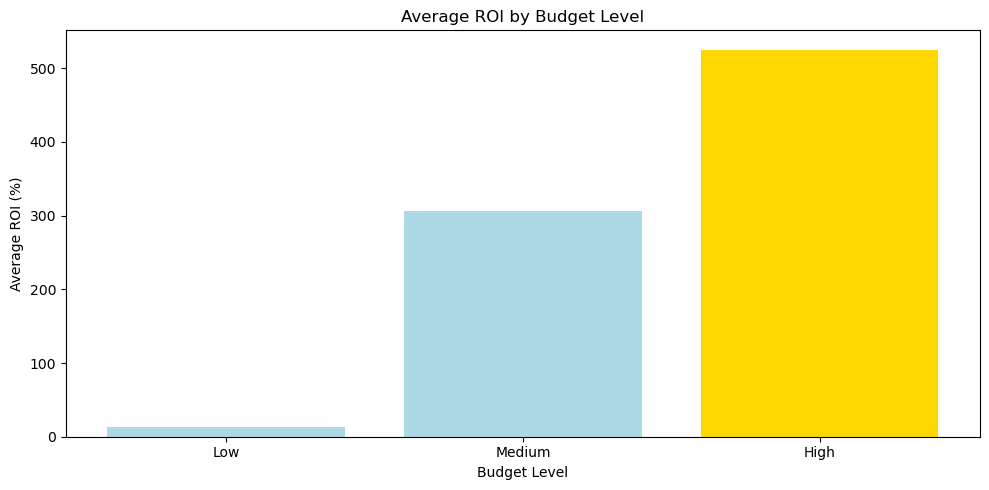

In [40]:
# Bar chart that highlights budget level with highest ROI
max_average_roi = average_roi['roi'].max()

colors = ['gold' if roi == max_average_roi else 'lightblue' for roi in average_roi['roi']]

x = average_roi['budget_level']
y = average_roi['roi']

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x, y, color=colors)
ax.set_title('Average ROI by Budget Level')
ax.set_xlabel('Budget Level')
ax.set_ylabel('Average ROI (%)')
plt.tight_layout();
# plt.savefig('images/rec2.png')

#### ROI by Budget Statistical Testing
Because I was comparing > 2 groups I used an ANOVA test to determine if there was a statistically significant difference between genres at an alpha of 0.05. My findings indicated that there was a difference so I followed up with Tukeys HSD test to understand the result.

H0: Average ROI is not significantly different between low budget, medium budget, and high budget films.

H1: Average ROI is significantly different between low budget, medium budget, and high budget films.

In [41]:
# Group the data by budget level
rec2_grouped_data = df_pos_rev.groupby('budget_level')['roi'].apply(list)
rec2_groups = [roi for roi in rec2_grouped_data]

# ANOVA
f_statistic, p_value = stats.f_oneway(*rec2_groups)

# Results
alpha = 0.05  # Significance level
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

if p_value < alpha:
    print("Reject the null hypothesis in favor of the alternative: There are significant differences in ROI at different budget levels.")
else:
    print("Fail to reject the null hypothesis: There are no significant differences in ROI at different budget levels.")

F-statistic: 16.339326760698317
P-value: 9.067360357049849e-08
Reject the null hypothesis in favor of the alternative: There are significant differences in ROI at different budget levels.


In [42]:
# Run Tukey's HSD test
rec2_tk_hsd = pairwise_tukeyhsd(endog=df_pos_rev['roi'], 
                            groups=df_pos_rev['budget_level'], 
                            alpha=0.05)

# Display the summary of results
print(rec2_tk_hsd.summary())

"""
The results of this table show that at each increasing budget level there is
a statistically significant difference in return on investment.
"""

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
  High    Low -512.6663    0.0 -724.9283 -300.4043   True
  High Medium -219.0246 0.0163 -405.5228  -32.5263   True
   Low Medium  293.6417 0.0068    66.997  520.2864   True
---------------------------------------------------------


'\nThe results of this table show that at each increasing budget level there is\na statistically significant difference in return on investment.\n'

Recommendation 2: Secure a minimum production budget of $5M (the more funding the better).

### Revenue by Release Month
The `release_date` included the month, day, and year but I was only interested in the month. I used string slicing to isolate the first three characters and assigned that to a new column `release_month`. Next I created a simplified dataframe called `revenue_by_month` which only displayed the month and the revenue. Because the data was not already organized by calendar months I had to set a custom order when graphing the bar chart. I also divided the numbers by 1,000,000 to increase readability and included color for the top 3 release months.

In [43]:
df_relevant

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209
1,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860
2,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382
3,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239
4,The Rum Diary,119.0,"[Comedy, Drama]",6.2,"Oct 28, 2011",45000000.0,2.154473e+07,-52.122818
...,...,...,...,...,...,...,...,...
2363,Earth,115.0,[Documentary],7.3,"Apr 22, 2009",47000000.0,1.167733e+08,148.453866
2364,Sisters,NaN,"[Action, Drama]",4.7,"Dec 18, 2015",30000000.0,1.060307e+08,253.435533
2365,Ali,110.0,[Drama],7.7,"Dec 25, 2001",109000000.0,8.768397e+07,-19.555994
2366,Columbus,85.0,[Comedy],5.8,"Aug 4, 2017",700000.0,1.110511e+06,58.644429


In [44]:
# Retrieve first 3 characters (month) from release_date and assign to new column
df_relevant.loc[:, 'release_month'] = df_relevant['release_date'].str.slice(0,3)
df_relevant

C:\Users\Elija\AppData\Local\Temp\ipykernel_26824\3051403924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant.loc[:, 'release_month'] = df_relevant['release_date'].str.slice(0,3)


,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi,release_month
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209,Dec
1,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.440860,Dec
2,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382,Sep
3,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239,Jun
4,The Rum Diary,119.0,"[Comedy, Drama]",6.2,"Oct 28, 2011",45000000.0,2.154473e+07,-52.122818,Oct
...,...,...,...,...,...,...,...,...,...
2363,Earth,115.0,[Documentary],7.3,"Apr 22, 2009",47000000.0,1.167733e+08,148.453866,Apr
2364,Sisters,NaN,"[Action, Drama]",4.7,"Dec 18, 2015",30000000.0,1.060307e+08,253.435533,Dec
2365,Ali,110.0,[Drama],7.7,"Dec 25, 2001",109000000.0,8.768397e+07,-19.555994,Dec
2366,Columbus,85.0,[Comedy],5.8,"Aug 4, 2017",700000.0,1.110511e+06,58.644429,Aug


In [45]:
# Focus the dataframe on release month and revenue
revenue_by_month = df_relevant.groupby('release_month')['revenue'].mean().reset_index()
revenue_by_month

,release_month,revenue
0,Apr,8.975570e+07
1,Aug,7.016496e+07
2,Dec,1.104012e+08
3,Feb,9.519347e+07
4,Jan,6.491876e+07
5,Jul,1.512905e+08
6,Jun,1.751684e+08
7,Mar,1.143526e+08
8,May,1.751695e+08
9,Nov,1.520912e+08


In [46]:
# Reorder to match calendar
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_relevant['release_month'] = pd.Categorical(df_relevant['release_month'], categories=month_order, ordered=True)

C:\Users\Elija\AppData\Local\Temp\ipykernel_26824\466434354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['release_month'] = pd.Categorical(df_relevant['release_month'], categories=month_order, ordered=True)


In [47]:
# Calculate mean revenue for each month and convert to Millions of Dollars
revenue_by_month = df_relevant.groupby('release_month')['revenue'].mean().reset_index()
revenue_by_month['revenue'] = round(revenue_by_month['revenue'] / 1000000, 1)

In [48]:
# Sort the DataFrame by the categorical month order
revenue_by_month = revenue_by_month.sort_values('release_month')
print(revenue_by_month)

   release_month  revenue
0            Jan     64.9
1            Feb     95.2
2            Mar    114.4
3            Apr     89.8
4            May    175.2
5            Jun    175.2
6            Jul    151.3
7            Aug     70.2
8            Sep     58.1
9            Oct     63.3
10           Nov    152.1
11           Dec    110.4


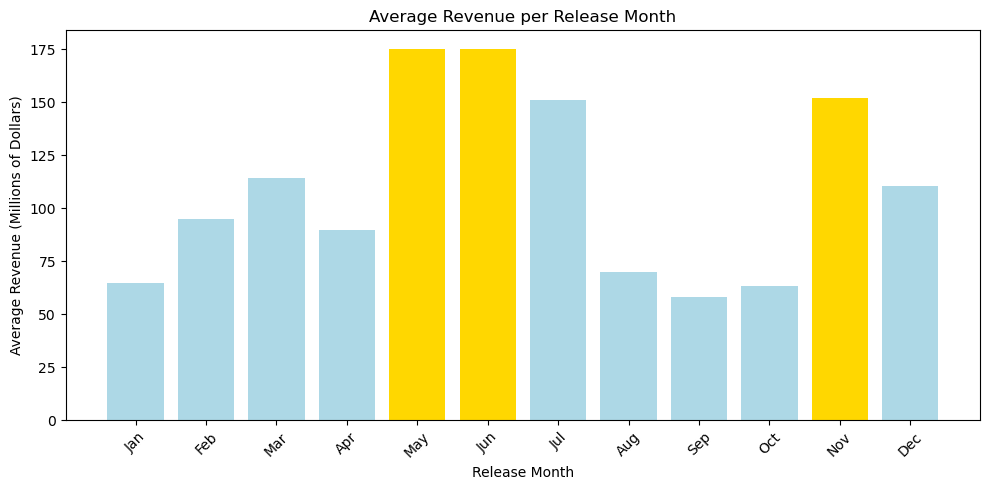

In [49]:
# Bar chart that highlights 3 months with highest average revenue
top_three_months = revenue_by_month.nlargest(3, 'revenue')['release_month'].values
colors = ['gold' if month in top_three_months else 'lightblue' for month in revenue_by_month['release_month']]

x = revenue_by_month['release_month']
y = revenue_by_month['revenue']

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x, y, color=colors)
ax.set_title('Average Revenue per Release Month')
ax.set_xlabel('Release Month')
ax.set_ylabel('Average Revenue (Millions of Dollars)')

ax.set_xticks(x)
ax.set_xticklabels(x, rotation=45)

plt.tight_layout();
# plt.savefig('images/rec3.png')

#### Revenue by Release Month Statistical Testing
Because I was comparing > 2 groups I used an ANOVA test to determine if there was a statistically significant difference between genres at an alpha of 0.05. My findings indicated that there was a difference so I followed up with Tukeys HSD test to understand the result.

H0: Average movie revenue is not significantly different between the different months of the year.

H1: Average movie revenue is significantly different between the different months of the year.

In [50]:
# Group the data by release month
rec3_grouped_data = df_relevant.groupby('release_month')['revenue'].apply(list)
rec3_groups = [revenue for revenue in rec3_grouped_data]

# ANOVA
f_statistic, p_value = stats.f_oneway(*rec3_groups)

# Results
alpha = 0.05  # Significance level
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

if p_value < alpha:
    print("Reject the null hypothesis in favor of the alternative: There are significant differences in average revenue in different release months.")
else:
    print("Fail to reject the null hypothesis: There are no significant differences in average revenue in different release months.")

F-statistic: 8.365428987632967
P-value: 1.3669502548846286e-14
Reject the null hypothesis in favor of the alternative: There are significant differences in average revenue in different release months.


In [51]:
# Run Tukey's HSD test
rec3_tk_hsd = pairwise_tukeyhsd(endog=df_relevant['revenue'], 
                            groups=df_relevant['release_month'], 
                            alpha=0.05)

# Display the summary of results
print(rec3_tk_hsd.summary())

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
group1 group2     meandiff    p-adj       lower          upper      reject
--------------------------------------------------------------------------
   Apr    Aug  -19590736.1238 0.9987  -87742562.5415  48561090.2938  False
   Apr    Dec   20645466.7062 0.9955  -41920187.6263  83211121.0386  False
   Apr    Feb    5437775.0772    1.0  -66031673.5635  76907223.7179  False
   Apr    Jan  -24836935.5047 0.9946  -98445584.5965  48771713.5871  False
   Apr    Jul   61534827.3776 0.1483   -8337845.4813 131407500.2366  False
   Apr    Jun   85412723.1014 0.0028   16749217.2577 154076228.9451   True
   Apr    Mar   24596899.4791 0.9906   -43722479.849  92916278.8071  False
   Apr    May   85413809.5499 0.0073   12476256.4141 158351362.6856   True
   Apr    Nov   62335531.0536 0.1125   -5899704.3644 130570766.4716  False
   Apr    Oct  -26491075.4217 0.9773  -92374761.5405   39392610.697  False
   Apr    Sep  -31683361.

In [52]:
"""
This table shows that there is a significant difference in revenue
between movies released in May, June, and November compared to September
and October but not with each other or the other calendar months, meaning
that the movie can be released any time during these months (May, Jun, Nov)
and perform similarly.
"""

rec3_results = pd.DataFrame(data=rec3_tk_hsd._results_table.data[1:], 
                          columns=rec3_tk_hsd._results_table.data[0])
rec3_results.query('reject == True and (group1 == "May" or group1 == "Jun" or group1 == "Nov")')

,group1,group2,meandiff,p-adj,lower,upper,reject
54,Jun,Oct,-1.119038e+08,0.0000,-1.776028e+08,-4.620481e+07,True
55,Jun,Sep,-1.170961e+08,0.0000,-1.853225e+08,-4.886969e+07,True
61,May,Oct,-1.119049e+08,0.0000,-1.820588e+08,-4.175100e+07,True
62,May,Sep,-1.170972e+08,0.0000,-1.896234e+08,-4.457096e+07,True
63,Nov,Oct,-8.882661e+07,0.0005,-1.540779e+08,-2.357534e+07,True
64,Nov,Sep,-9.401889e+07,0.0004,-1.618143e+08,-2.622353e+07,True


Recommendation 3: Release the movie in May, June, or November.

## Results


### Ratings by Genre
* There are 19 unique genres with average ratings between 5.5 and 7.1 out of 10.
* Documentaries, biographies, and historical movies had highest average ratings.
* Statistical Analysis using an alpha = 0.05 shows that:
    * Documentaries (7.1/10) were rated higher than 10 other genres at a significant level
    * Biographies (7.0/10) were rated higher than 9 other genres at a significant level
    * Historical movies (6.8/10) were rated higher than 4 other genres at a significant level


### ROI by Budget
* ROI by Budget
    * Low: 12.6%
    * Medium: 306.2%
    * High: 525.2%
* ROI is higher for higher budget films.
* Statistical Analysis using an alpha = 0.05 shows that the difference in ROI is significant across all budget levels.


### Revenue by Release Month
* Across all months May, June, and November recorded the highest gross revenue.
* Statistical Analysis using an alpha = 0.05 shows that the difference in revenue is significant between each of these months and September and October but they are not statistically different from each other or the other calendar months.

## Conclusions
This analysis leads to three recommendations.

1. Create a historical movie, a biography, or a documentary. This will likely receive the highest ratings and build credibility with the target audience.

2. Secure a minimum production budget of $5M. This target will set a reasonable goal for an emerging movie studio while capturing the significant increase in ROI that will allow the movie to be profitable and continue future productions.

3. Release the movie in May, June, or November. This will maximize the likelihood of ticket sales as May and June kick off the summer months and November leads into the holiday season, both corresponding to increased family activity.

## Next Steps
* Decide which genre best matches the interest and capability of the production crew.
* Seek funding through banks, private equity, or partnerships.
* Time production (casting, filming, editing, etc.) so that the movie can premiere at the optimal time.